In [35]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import set_random_seed
# for reproducibility 
np.random.seed(1)
set_random_seed(1)

from keras.layers import Dense, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dropout, Activation, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

In [36]:
# Multi-input classifier - Rectangle outlier samples

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self):
        self.number_of_classes = 2
        self.input_dim = 2
        self.epochs = 200
        self.batch_size = 32
        # There are 2 inlier circles
        # Inlier circle centers on the 1st axis; for all other dimensions, the centers are at 0.
        self.x1 = -10
        self.x2 = +10
        self.r = 2.0
        # Number of inlier samples for each class
        self.n = 1000
        # width of the outlier outer square side
        self.s = 100

        self.data, self.labels, self.data_out, self.labels_out = self.get_data()
        print(self.data.shape, self.labels.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.5, shuffle=True, stratify=self.labels,
                                                            random_state=1)
        self.X_train_outliers, self.X_test_outliers, self.y_train_outliers, self.y_test_outliers = train_test_split(self.data_out, self.labels_out, test_size=0.5, shuffle=True,
                                                            random_state=1)
        self.multi_input_classifier, self.model = self.get_model()

        self.mu = np.mean(np.concatenate((self.X_train, self.X_train_outliers), axis=0), axis=0)
        self.sigma = np.std(np.concatenate((self.X_train, self.X_train_outliers), axis=0), axis=0)

        self.data = self.preprocess_data(self.data)
        self.data_out = self.preprocess_data(self.data_out)
        self.X_train = self.preprocess_data(self.X_train)
        self.X_test = self.preprocess_data(self.X_test)
        self.X_train_outlier = self.preprocess_data(self.X_train_outliers)
        self.X_test_outliers = self.preprocess_data(self.X_test_outliers)


    # return True if point p (a list) lies inside a hypersphere centered at the origin with radius r
    def is_in_hypersphere(self, r, p):
        p = np.array(p)
        return np.sum(p*p) <= r**2


    # return True if point p (a list) lies inside a hypersphere centered at the (x, 0, 0, ...) with radius r
    def is_in_hypersphere_centered_at(self, x, r, p):
        p = np.array(p)
        p[0] -= x
        return np.sum(p*p) <= r**2


    # uniformly sample a point from a square centered at the origin with side = s
    def sample_point_from_square(self, s):
        p = []
        # first point
        for i in range(0, self.input_dim):
            p.append(np.random.uniform(-1*s/2, s/2, 1))
        return p


    def preprocess_data(self, x):
        #return (x-self.mu)/self.sigma
        return x

    # sample points from 2D gaussian centered at origin
    def sample_point_from_gaussian(self, sigma):
        mean = np.zeros(self.input_dim)
        cov = np.zeros((self.input_dim, self.input_dim), np.float32)
        np.fill_diagonal(cov, sigma*sigma)
        p = list(np.random.multivariate_normal(mean, cov, 1).T.squeeze())
        return p

        
    # sample from a hypersphre with rejection sampling
    def get_gaussian_data(self, x, r, n):
        data = np.zeros((n, self.input_dim))
        count = 0
        while count<n:
            data[count, :] = self.sample_point_from_gaussian(r)
            # update the point with offset for the 1st dimension
            data[count, 0] += x
            count += 1

        data = data.astype(np.float32)
        return data
        # plt.scatter(x, y, s = 4)

    # generate n outlier points uniformly sampled within square centered at the origin
    # with side=s, excuding the inlier circles
    def get_outlier_data_sub(self, s, x1, x2, r, n):
        count = 0
        data = np.zeros((n, self.input_dim))
        while count < n:
            p = self.sample_point_from_square(s)
            if (not self.is_in_hypersphere_centered_at(x1, r, p)) and (not self.is_in_hypersphere_centered_at(x2, r, p)):
                data[count, :] = p
                count += 1
        return data

    def get_outlier_data(self):
        data = self.get_outlier_data_sub(self.s, self.x1, self.x2, self.r*3, 2*self.n)
        return data.astype(np.float32)

        
    def get_data(self):
        # class 0 data
        data = self.get_gaussian_data(self.x1, self.r, self.n)
        labels = np.ones((self.n, 1))*0
        print(labels.shape)
        # class 1 data
        data = np.concatenate((data, self.get_gaussian_data(self.x2, self.r, self.n)), axis=0)
        labels = np.concatenate((labels, np.ones((self.n, 1))*1), axis=0)
        print(labels.shape)
        # outlier data
        data_out = self.get_outlier_data()
        labels_out = np.ones((2*self.n,1))*2
        print(labels.shape)
        return data.astype(np.float32), labels.astype(np.float32), data_out.astype(np.float32), labels_out.astype(np.float32)

    
    def base_model(self):
        model = Sequential()
        model.add(Dense(500, input_shape=(self.input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))
        #model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
        return model

    def get_model(self):
        # instantiate classifier model
        classifier = self.base_model()
        classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))

        # just the classifier
        input_data = Input(shape=(self.input_dim, ))
        y_classifier = classifier(input_data)


        # 2 input classifier
        input_a = Input(shape=(self.input_dim, ))
        processed_a = classifier(input_a)
        input_b = Input(shape=(self.input_dim, ))
        processed_b = classifier(input_b)

        out_a = Lambda(lambda x: x, name = 'out_a')(processed_a)
        out_b = Lambda(lambda x: x, name = 'out_b')(processed_b)

        multi_input_classifier = Model(inputs=[input_a, input_b], outputs=[out_a, out_b])
        multi_input_classifier.compile(loss={'out_a':'categorical_crossentropy', 'out_b':'categorical_crossentropy'}, 
                                       loss_weights={'out_a': 1.0, 'out_b': 1.0}, optimizer=Adam(0.001), 
                                       metrics={'out_a':['acc'], 'out_b':['categorical_crossentropy']})


        mnist_model = Model(input_data, y_classifier)
        mnist_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])

        return multi_input_classifier, mnist_model


    def train(self):
        # fit the model
        Y_train = np_utils.to_categorical(self.y_train, self.number_of_classes)
        Y_train_outliers = np.ones((self.y_train_outliers.shape[0], self.number_of_classes))
        Y_test = np_utils.to_categorical(self.y_test, self.number_of_classes)
        Y_test_outliers = np.ones((self.y_test_outliers.shape[0], self.number_of_classes))

        self.multi_input_classifier.fit([self.X_train, self.X_train_outliers], [Y_train, Y_train_outliers], 
                                        epochs=self.epochs, validation_data=([self.X_test, self.X_test_outliers], [Y_test, Y_test_outliers]), batch_size=self.batch_size)     
        

In [37]:
classifier = Classifier()

classifier.train()

(1000, 1)
(2000, 1)
(2000, 1)
((2000, 2), (2000, 1))
Train on 1000 samples, validate on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 0s 415us/step - loss: 2.6484 - out_a_loss: 0.5141 - out_b_loss: 2.1343 - out_a_acc: 0.8660 - out_b_categorical_crossentropy: 2.1343 - val_loss: 1.9879 - val_out_a_loss: 0.4369 - val_out_b_loss: 1.5509 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.5509
Epoch 2/200
1000/1000 [==============================] - 0s 113us/step - loss: 1.9467 - out_a_loss: 0.4437 - out_b_loss: 1.5030 - out_a_acc: 0.9990 - out_b_categorical_crossentropy: 1.5030 - val_loss: 1.8762 - val_out_a_loss: 0.4162 - val_out_b_loss: 1.4599 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4599
Epoch 3/200
1000/1000 [==============================] - 0s 115us/step - loss: 1.8693 - out_a_loss: 0.3696 - out_b_loss: 1.4997 - out_a_acc: 0.9990 - out_b_categorical_crossentropy: 1.4997 - val_loss: 1.8499 - val_out_a_loss: 0.3356 - val_out_b_

Epoch 26/200
1000/1000 [==============================] - 0s 116us/step - loss: 1.4257 - out_a_loss: 0.0150 - out_b_loss: 1.4107 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4107 - val_loss: 1.4303 - val_out_a_loss: 0.0125 - val_out_b_loss: 1.4178 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4178
Epoch 27/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.4282 - out_a_loss: 0.0155 - out_b_loss: 1.4126 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4126 - val_loss: 1.4320 - val_out_a_loss: 0.0207 - val_out_b_loss: 1.4113 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4113
Epoch 28/200
1000/1000 [==============================] - 0s 111us/step - loss: 1.4242 - out_a_loss: 0.0182 - out_b_loss: 1.4059 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4059 - val_loss: 1.4224 - val_out_a_loss: 0.0128 - val_out_b_loss: 1.4096 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4096
Epoch 29/200
100

Epoch 51/200
1000/1000 [==============================] - 0s 114us/step - loss: 1.4106 - out_a_loss: 0.0131 - out_b_loss: 1.3976 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3976 - val_loss: 1.4338 - val_out_a_loss: 0.0074 - val_out_b_loss: 1.4264 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4264
Epoch 52/200
1000/1000 [==============================] - 0s 102us/step - loss: 1.4104 - out_a_loss: 0.0105 - out_b_loss: 1.3999 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3999 - val_loss: 1.4122 - val_out_a_loss: 0.0070 - val_out_b_loss: 1.4052 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4052
Epoch 53/200
1000/1000 [==============================] - 0s 102us/step - loss: 1.4073 - out_a_loss: 0.0090 - out_b_loss: 1.3982 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3982 - val_loss: 1.4071 - val_out_a_loss: 0.0090 - val_out_b_loss: 1.3981 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3981
Epoch 54/200
100

Epoch 76/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.4014 - out_a_loss: 0.0074 - out_b_loss: 1.3939 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3939 - val_loss: 1.4026 - val_out_a_loss: 0.0071 - val_out_b_loss: 1.3955 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3955
Epoch 77/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.3989 - out_a_loss: 0.0064 - out_b_loss: 1.3925 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3925 - val_loss: 1.4060 - val_out_a_loss: 0.0050 - val_out_b_loss: 1.4010 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4010
Epoch 78/200
1000/1000 [==============================] - 0s 109us/step - loss: 1.4058 - out_a_loss: 0.0104 - out_b_loss: 1.3954 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3954 - val_loss: 1.4039 - val_out_a_loss: 0.0130 - val_out_b_loss: 1.3909 - val_out_a_acc: 0.9990 - val_out_b_categorical_crossentropy: 1.3909
Epoch 79/200
100

Epoch 101/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.3990 - out_a_loss: 0.0071 - out_b_loss: 1.3919 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3919 - val_loss: 1.4031 - val_out_a_loss: 0.0079 - val_out_b_loss: 1.3952 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3952
Epoch 102/200
1000/1000 [==============================] - 0s 107us/step - loss: 1.4016 - out_a_loss: 0.0071 - out_b_loss: 1.3945 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3945 - val_loss: 1.4089 - val_out_a_loss: 0.0125 - val_out_b_loss: 1.3963 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3963
Epoch 103/200
1000/1000 [==============================] - 0s 102us/step - loss: 1.4057 - out_a_loss: 0.0093 - out_b_loss: 1.3964 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3964 - val_loss: 1.4037 - val_out_a_loss: 0.0094 - val_out_b_loss: 1.3943 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3943
Epoch 104/200

Epoch 126/200
1000/1000 [==============================] - 0s 111us/step - loss: 1.3962 - out_a_loss: 0.0052 - out_b_loss: 1.3910 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3910 - val_loss: 1.4012 - val_out_a_loss: 0.0086 - val_out_b_loss: 1.3926 - val_out_a_acc: 0.9990 - val_out_b_categorical_crossentropy: 1.3926
Epoch 127/200
1000/1000 [==============================] - 0s 113us/step - loss: 1.4020 - out_a_loss: 0.0082 - out_b_loss: 1.3938 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3938 - val_loss: 1.4015 - val_out_a_loss: 0.0060 - val_out_b_loss: 1.3954 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3954
Epoch 128/200
1000/1000 [==============================] - 0s 137us/step - loss: 1.4016 - out_a_loss: 0.0075 - out_b_loss: 1.3941 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3941 - val_loss: 1.4175 - val_out_a_loss: 0.0251 - val_out_b_loss: 1.3923 - val_out_a_acc: 0.9990 - val_out_b_categorical_crossentropy: 1.3923
Epoch 129/200

Epoch 151/200
1000/1000 [==============================] - 0s 102us/step - loss: 1.4015 - out_a_loss: 0.0079 - out_b_loss: 1.3936 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3936 - val_loss: 1.4049 - val_out_a_loss: 0.0098 - val_out_b_loss: 1.3951 - val_out_a_acc: 0.9990 - val_out_b_categorical_crossentropy: 1.3951
Epoch 152/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.3982 - out_a_loss: 0.0077 - out_b_loss: 1.3905 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3905 - val_loss: 1.4080 - val_out_a_loss: 0.0068 - val_out_b_loss: 1.4012 - val_out_a_acc: 0.9990 - val_out_b_categorical_crossentropy: 1.4012
Epoch 153/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4075 - out_a_loss: 0.0106 - out_b_loss: 1.3968 - out_a_acc: 0.9980 - out_b_categorical_crossentropy: 1.3968 - val_loss: 1.4089 - val_out_a_loss: 0.0117 - val_out_b_loss: 1.3972 - val_out_a_acc: 0.9970 - val_out_b_categorical_crossentropy: 1.3972
Epoch 154/200

Epoch 176/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.4010 - out_a_loss: 0.0100 - out_b_loss: 1.3910 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3910 - val_loss: 1.4063 - val_out_a_loss: 0.0049 - val_out_b_loss: 1.4014 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4014
Epoch 177/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.3954 - out_a_loss: 0.0051 - out_b_loss: 1.3903 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3903 - val_loss: 1.4017 - val_out_a_loss: 0.0085 - val_out_b_loss: 1.3932 - val_out_a_acc: 0.9970 - val_out_b_categorical_crossentropy: 1.3932
Epoch 178/200
1000/1000 [==============================] - 0s 112us/step - loss: 1.3950 - out_a_loss: 0.0055 - out_b_loss: 1.3896 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3896 - val_loss: 1.4007 - val_out_a_loss: 0.0047 - val_out_b_loss: 1.3960 - val_out_a_acc: 0.9990 - val_out_b_categorical_crossentropy: 1.3960
Epoch 179/200

<IPython.core.display.Javascript object>


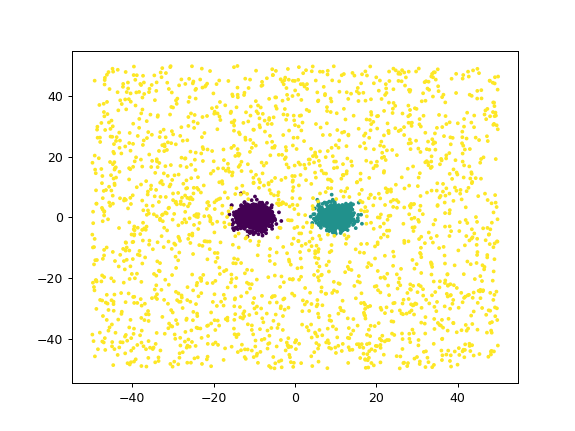

In [38]:
# Plot input data

data = np.concatenate((classifier.data, classifier.data_out), axis=0)
labels = np.concatenate((classifier.labels, classifier.labels_out), axis=0)
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=4, c=labels.squeeze())


<IPython.core.display.Javascript object>


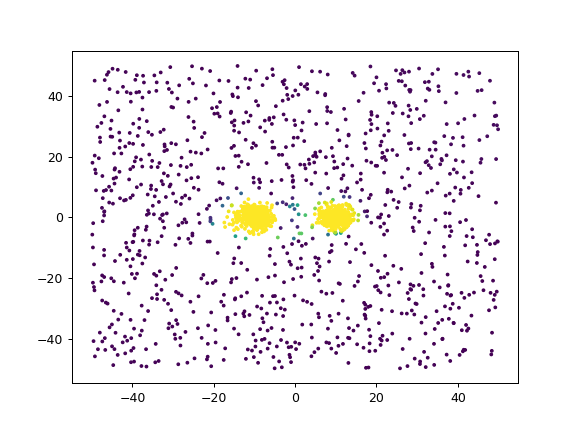

In [39]:
# Plot classified data - for test data

X_test = np.concatenate((classifier.X_test, classifier.X_test_outliers), axis=0)
y_test = np.concatenate((classifier.y_test, classifier.y_test_outliers), axis=0)

y_pred = classifier.model.predict(X_test)
y_max = y_pred.max(axis = -1)
#plt.scatter(X_test[:, 0], X_test[:, 1], s=4, c=y_max.squeeze())

# Plot classified data - for test data

y_labels = y_pred.argmax(axis = -1)

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

#ax.scatter(X_test[:, 0], X_test[:, 1], y_max, c=y_test.squeeze())
plt.scatter(X_test[:, 0], X_test[:, 1], s=4, c=y_max.squeeze())

In [40]:
# Create image for paper
classifier.n = 400
data, labels, data_out, labels_out = classifier.get_data()
ind_0 = np.where(labels==0)[0][0:50]
ind_1 = np.where(labels==1)[0][0:50]
ind_2 = np.where(labels_out==2)[0]
ind = np.random.randint(0, ind_2.shape[0], 200)
ind_2 = ind_2[ind]
data = np.concatenate((data[ind_0,:], data[ind_1,:], data_out[ind_2,:]), axis=0)
labels = np.concatenate((labels[ind_0,:], labels[ind_1,:], labels_out[ind_2,:]), axis=0)
#data_outlier, labels_outlier = classifier.get_outlier_data()
#data = np.concatenate((data, data_outlier), axis=0)
#labels = np.concatenate((labels, labels_outlier))
print(data.shape)
print(labels.shape)

(400, 1)
(800, 1)
(800, 1)
(300, 2)
(300, 1)


<IPython.core.display.Javascript object>


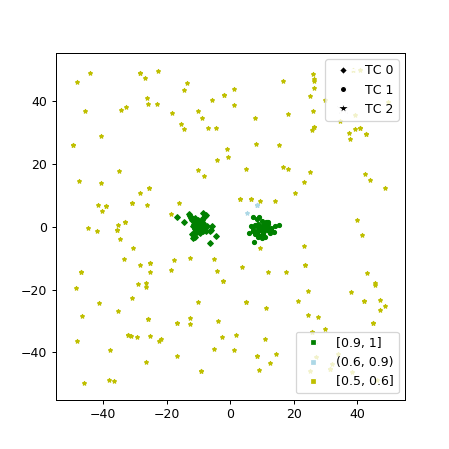

In [50]:
y_pred = classifier.model.predict(data)
y_labels = y_pred.argmax(axis = -1)
y_max = y_pred.max(axis = -1)

ind = np.where(y_max <= 0.6)[0]
y_labels[ind] = 2

ind = np.where(y_max >= 0.6)[0]
y_labels[ind] = 0

ind = np.where(((y_max > 0.6) & (y_max < 0.9)))[0]
y_labels[ind] = 1


c_list = ['g', '#ADD8E6', 'y']
marker_list = ['D', 'o', '*']
plt.figure(figsize=(5,5))
for i in range(0, data.shape[0]):
    marker = marker_list[int(labels[i])]
    c = c_list[y_labels[i]]
    plt.scatter(data[i, 0], data[i, 1], s=10, c=c, marker=marker)

plt.legend(('$class\ 0$','$class\ 1$','$OOD\ sample$'), fontsize='x-small');
import matplotlib.lines as lines
dimond_line = lines.Line2D([0], [0], color='w', marker='D', markerfacecolor='#000000',
                          markersize=5, label='TC 0')

circle_line = lines.Line2D([0], [0], marker='o', color='w', label='TC 1',
                          markerfacecolor='#000000', markersize=5)

star_line = lines.Line2D([0], [0], color='w', marker='*', markerfacecolor='#000000',
                          markersize=10, label='TC 2')


green_line = lines.Line2D([0], [0], marker='s', color='w', label='[0.9, 1]',
                          markerfacecolor='g', markersize=5)


lightblue_line = lines.Line2D([0], [0], marker='s', color='w', label='(0.6, 0.9)',
                          markerfacecolor='#ADD8E6', markersize=5)


yellow_line = lines.Line2D([0], [0], marker='s', color='w', label='[0.5, 0.6]',
                          markerfacecolor='y', markersize=5)

# Create a legend for the first line.
first_legend = plt.legend(handles=[dimond_line, circle_line, star_line], loc=1)


# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=[green_line, lightblue_line, yellow_line], loc=4)

plt.show()
plt.savefig("exp2_b")

In [32]:
print(y_max.shape)
print(np.where(y_max>0.95)[0].shape)
print(np.where(y_max<0.55)[0].shape)

(300,)
(98,)
(196,)


In [33]:
np.unique(y_test)

array([0., 1., 2.], dtype=float32)

In [34]:
print(np.where(y_test==0)[0].shape)

(500,)
